In [67]:
# produce supplementary figure on interrater reliability
#4 panels
# panel 1 - zoomed in view of 3 lesion masks
# ?plus predicted lesions??
# 4 raincloud plots of lesion areas
# 4 DICE overlaps
# 4 distances. geodesic distance from border of 1 lesion to border of the other
# background = 1, 1 lesion = 1, 2 masks = 2. Distance from 2-0 through 1.
# store max per subject
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#get ids of masks and load them
import glob
import nibabel as nb
import numpy as np


mask_filenames=glob.glob('/rds/user/kw350/rds-kw350-meld/meld_data/inter_rater_masks/*')
subject_ids = []
raters=['RG','KM']
masks = {}
for rater in raters:
    masks[rater]={}

#get subjids and load data
hemis={}
for mf in mask_filenames:
    subj = mf.split('.')[1]
    hemi = mf.split('.')[0].split('/')[-1]
    if subj not in subject_ids:
        subject_ids.append(subj)
        hemis[subj]=hemi
    for rater in raters:
        if rater in mf:
            masks[rater][subj] = np.asanyarray(nb.load(mf).dataobj).ravel()

In [11]:
#load predictions
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
import os
import matplotlib_surface_plotting as msp
import h5py
import ptitprince as pt

def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [38]:
masks['prediction']={}
for subject in subject_ids:
    print(subject)
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    masks['prediction'][subject]=result_hemis[hemis[subject]]
    full=np.zeros_like(cohort.cortex_mask)
    full[cohort.cortex_mask] = result_hemis[hemis[subject]]
    masks['prediction'][subject]=full
    print(sum(np.logical_and(masks['prediction'][subject]>0,masks['KM'][subject]>0)))

MELD_H4_15T_FCD_0022
0
MELD_H4_3T_FCD_0031
897
MELD_H4_15T_FCD_0006
914
MELD_H4_3T_FCD_0032
526
MELD_H4_3T_FCD_0033
273
MELD_H4_3T_FCD_0010
0
MELD_H4_15T_FCD_0005
0
MELD_H4_3T_FCD_0016
1311
MELD_H4_3T_FCD_0006
1260
MELD_H4_15T_FCD_0004
1622


MELD_H4_15T_FCD_0022
(array([0, 1, 2, 3]), array([162667,    199,    294,    682]))
MELD_H4_3T_FCD_0031
(array([0, 1, 2]), array([126776,  33355,   3711]))
MELD_H4_15T_FCD_0006
(array([0, 1, 2, 3]), array([161017,    274,   1655,    896]))
MELD_H4_3T_FCD_0032
(array([0, 1, 2, 3]), array([154947,   3250,   5642,      3]))
MELD_H4_3T_FCD_0033
(array([0, 1, 2, 3]), array([163163,     29,    356,    294]))
MELD_H4_3T_FCD_0010
(array([0, 1, 2, 3]), array([160446,    344,   2909,    143]))
MELD_H4_15T_FCD_0005
(array([0, 1, 2]), array([160439,      4,   3399]))
MELD_H4_3T_FCD_0016
(array([0, 1, 3]), array([155855,   7404,    583]))
MELD_H4_3T_FCD_0006
(array([0, 1, 2, 3]), array([161633,   1597,     63,    549]))
MELD_H4_15T_FCD_0004
(array([0, 1, 2, 3]), array([154839,   3782,   3759,   1462]))


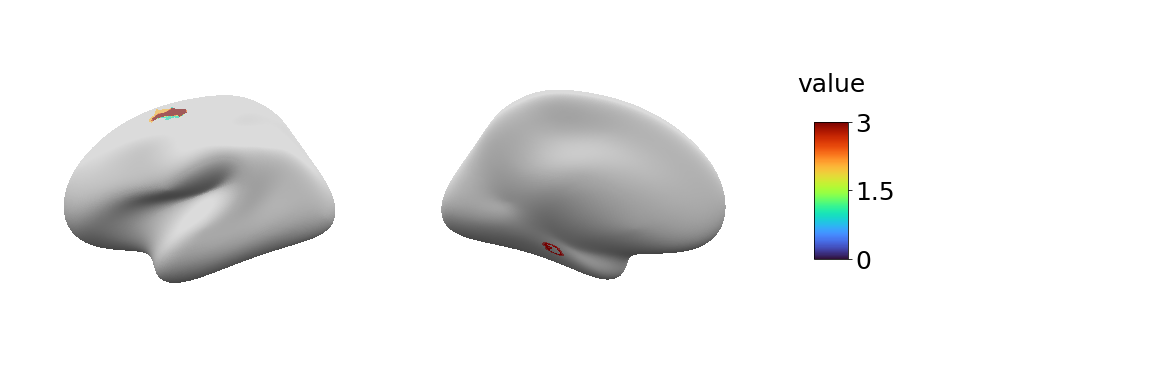

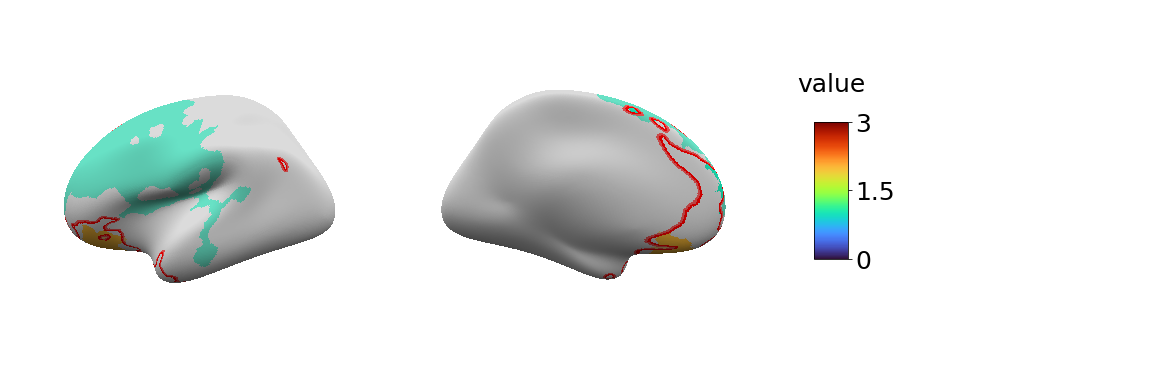

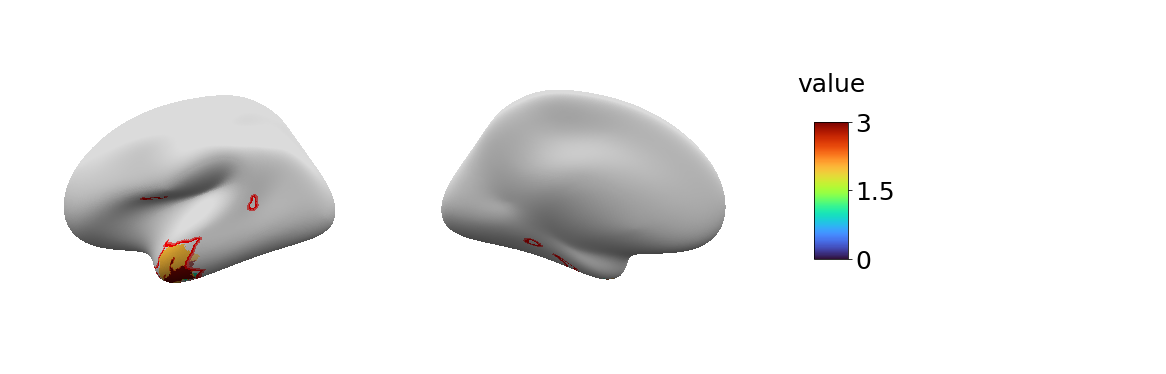

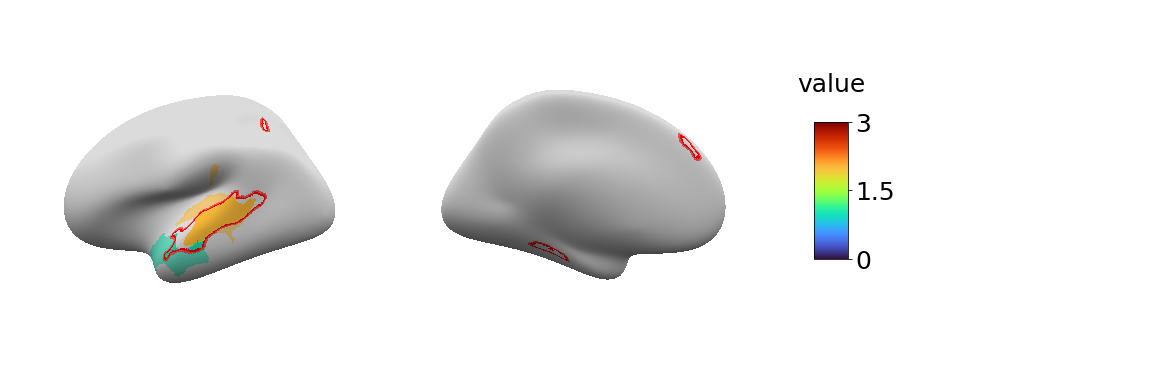

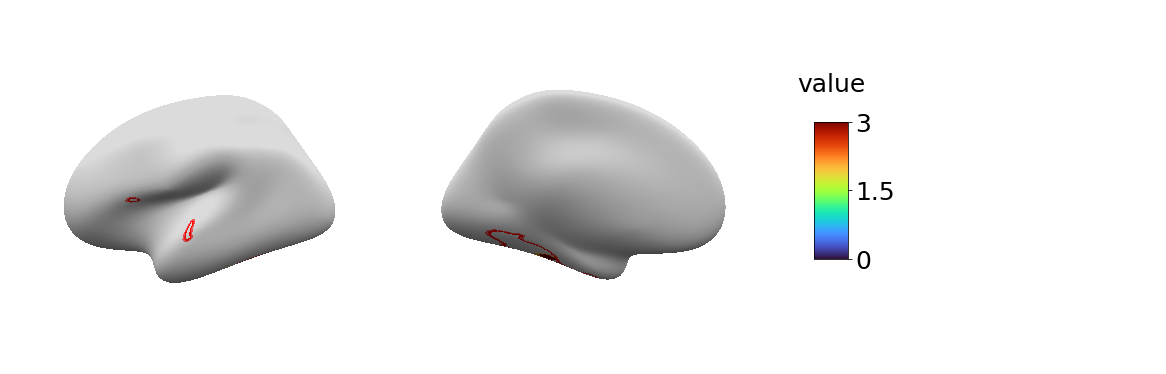

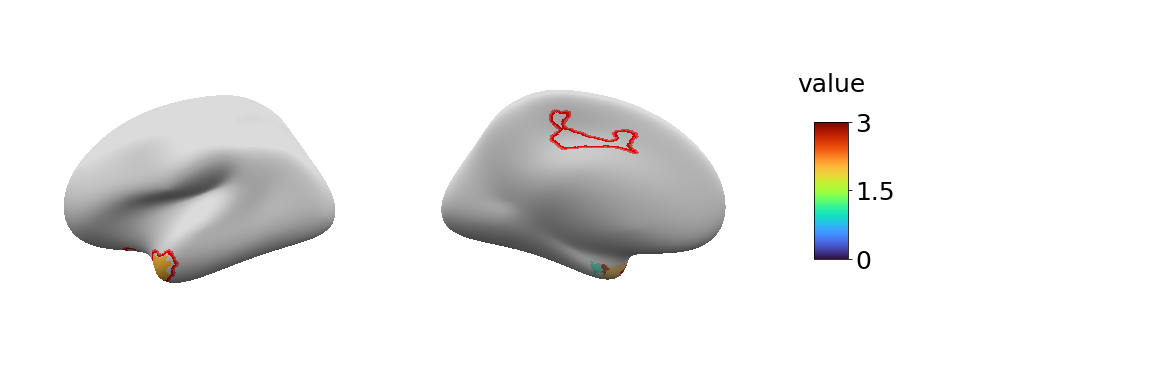

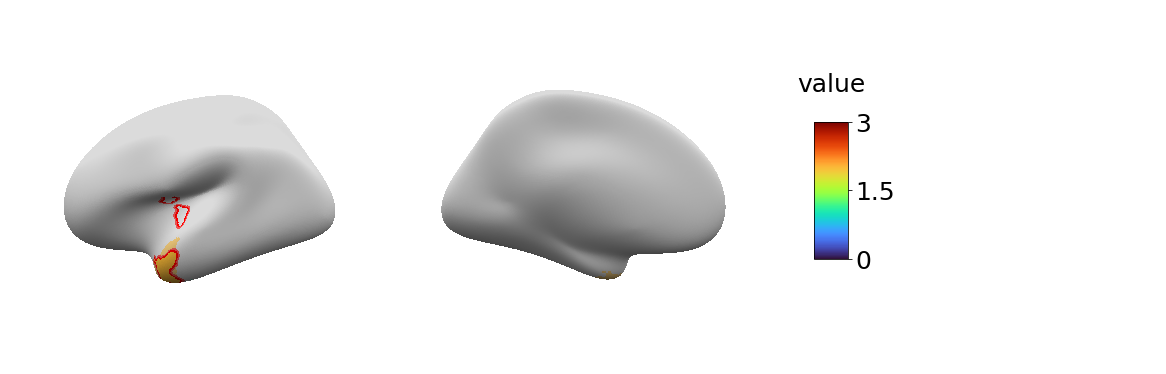

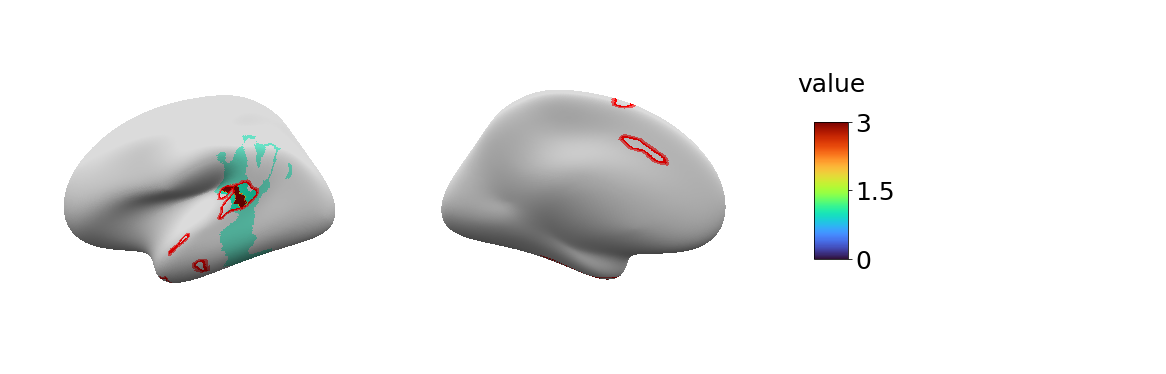

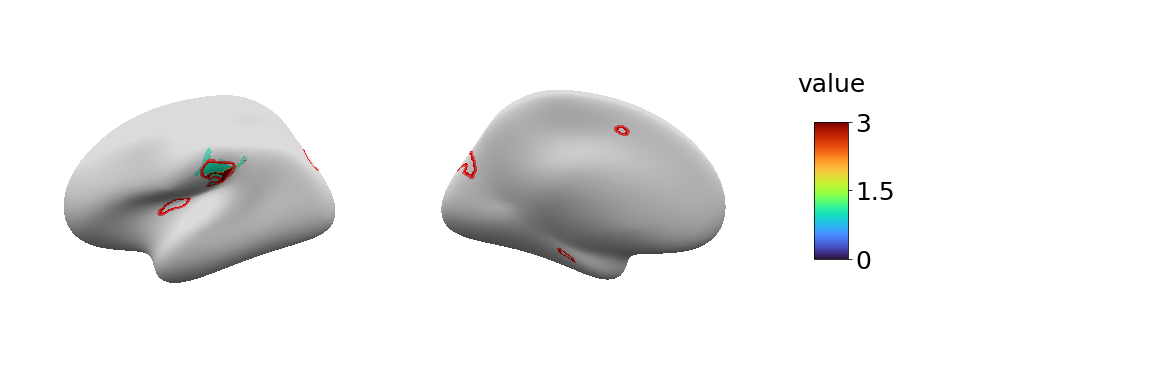

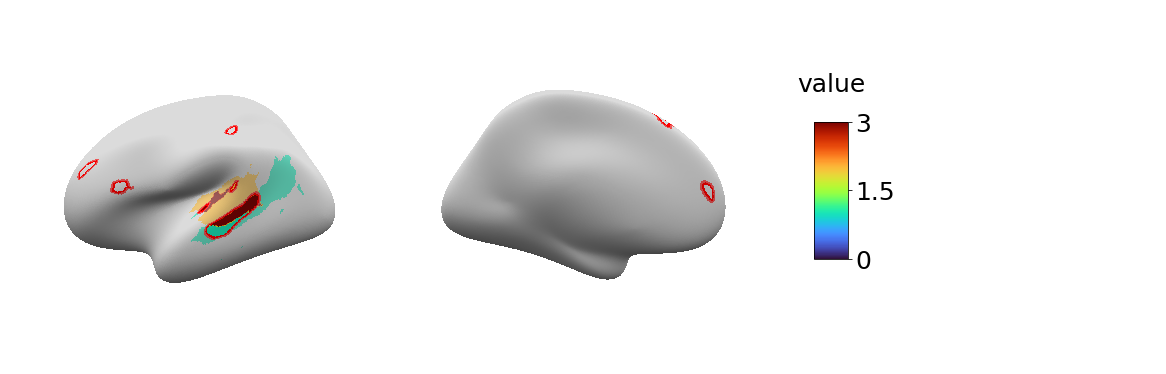

In [48]:
import matplotlib_surface_plotting as msp
overlays=[]
for subject in subject_ids:
    print(subject)
    combi = (masks['KM'][subject]>0).astype(int) + 2* (masks['RG'][subject]>0).astype(int)
    print(np.unique(combi,return_counts=True))
    
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],combi,cmap='turbo',mask=combi==0,
                  pvals=masks['prediction'][subject],
                 vmin=0,vmax=3,colorbar=True)
    break

/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


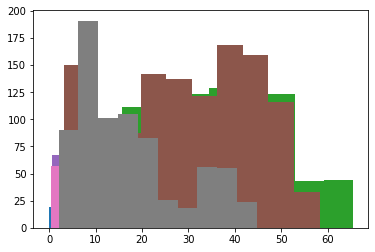

In [79]:
#calculate distances
import potpourri3d as pp3d
def flatten(t):
    return [item for sublist in t for item in sublist]

solver = pp3d.MeshHeatMethodDistanceSolver(cohort.surf["coords"],
                                           cohort.surf["faces"])
med_dists=[]
for subject in subject_ids:
    overlap_vertices = np.where(np.logical_and(masks['KM'][subject]>0,masks['RG'][subject]>0))[0]
    if len(overlap_vertices)>0:
        distances=solver.compute_distance_multisource(overlap_vertices)
        #edge vertices =
        combi_mask  = np.where(np.logical_or(masks['KM'][subject]>0,masks['RG'][subject]>0))[0]

        neighbours = np.unique(flatten(np.array(cohort.neighbours)[combi_mask]))
        edge_vertices=np.setdiff1d(neighbours,combi_mask)
        plt.hist(distances[edge_vertices])
        med_dists.append(np.mean(distances[edge_vertices]))
        

In [80]:
np.mean(med_dists)

15.952388067954253